1. Download/Load NIFTY stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import sklearn
warnings.filterwarnings('ignore')

ysymbol=['ADANIENT.NS',
'ADANIPORTS.NS',
'APOLLOHOSP.NS',
'ASIANPAINT.NS',
'AXISBANK.NS',
'BAJAJ-AUTO.NS',
'BAJFINANCE.NS',
'BAJAJFINSV.NS',
'BPCL.NS',
'BHARTIARTL.NS',
'BRITANNIA.NS',
'CIPLA.NS',
'COALINDIA.NS',
'DIVISLAB.NS',
'DRREDDY.NS',
'EICHERMOT.NS',
'GRASIM.NS',
'HCLTECH.NS',
'HDFCBANK.NS',
'HDFCLIFE.NS',
'HEROMOTOCO.NS',
'HINDALCO.NS',
'HINDUNILVR.NS',
'ICICIBANK.NS',
'ITC.NS',
'INDUSINDBK.NS',
'INFY.NS',
'JSWSTEEL.NS',
'KOTAKBANK.NS',
'LTIM.NS',
'LT.NS',
'M&M.NS',
'MARUTI.NS',
'NTPC.NS',
'NESTLEIND.NS',
'ONGC.NS',
'POWERGRID.NS',
'RELIANCE.NS',
'SBILIFE.NS',
'SBIN.NS',
'SUNPHARMA.NS',
'TCS.NS',
'TATACONSUM.NS',
'TATAMOTORS.NS',
'TATASTEEL.NS',
'TECHM.NS',
'TITAN.NS',
'UPL.NS',
'ULTRACEMCO.NS',
'WIPRO.NS']

# Yahoo finance takes nse stocks ending with .ns



end_date = '2023-12-23'
# data fro previous 8 years
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=ysymbol,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[*********************100%%**********************]  50 of 50 completed


adj close        close         high          low  \
date       ticker                                                              
2015-12-28 ADANIENT.NS      44.368435    45.771702    46.507320    45.090576   
           ADANIPORTS.NS   250.485840   262.000000   263.000000   257.100006   
           APOLLOHOSP.NS  1402.133423  1442.349976  1452.000000  1437.599976   
           ASIANPAINT.NS   834.538025   881.049988   886.250000   876.750000   
           AXISBANK.NS     445.055756   455.350006   456.600006   448.399994   
...                               ...          ...          ...          ...   
2023-12-22 TECHM.NS       1275.150024  1275.150024  1280.900024  1242.500000   
           TITAN.NS       3627.350098  3627.350098  3638.449951  3560.550049   
           ULTRACEMCO.NS  9969.000000  9969.000000  9999.000000  9902.000000   
           UPL.NS          581.650024   581.650024   585.750000   577.400024   
           WIPRO.NS        462.649994   462.649994   466.299988   434.000000   

                                 open      volume  
date       ticker                                  
2015-12-28 ADANIENT.NS      45.771702   3912777.0  
           ADANIPORTS.NS   259.000000   2392484.0  
           APOLLOHOSP.NS  1448.000000     75240.0  
           ASIANPAINT.NS   882.000000    633270.0  
           AXISBANK.NS     450.000000   5914945.0  
...                               ...         ...  
2023-12-22 TECHM.NS       1260.000000   2297352.0  
           TITAN.NS       3580.000000    777099.0  
           ULTRACEMCO.NS  9987.000000    226940.0  
           UPL.NS          581.000000   2464945.0  
           WIPRO.NS        435.299988  23040407.0  

[97706 rows x 6 columns]

2. Calculate features and technical indicators for each stock.
Garman-Klass Volatility
RSI
Bollinger Bands
ATR
MACD
Nifty Rupees Volume

In [2]:
df['garman_klass_vol']=((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

#pandas_ta  is a library that leverages the Pandas package with more than 130 Indicators and Utility functions and more than 60 TA Lib Candlestick Patterns. 
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
#The rupees  volume is the total value of the shares traded. the value is in lakhs 
df['rupees_volume'] = (df['adj close'] * df['volume']) / 1e5

df

adj close        close         high          low  \
date       ticker                                                              
2015-12-28 ADANIENT.NS      44.368435    45.771702    46.507320    45.090576   
           ADANIPORTS.NS   250.485840   262.000000   263.000000   257.100006   
           APOLLOHOSP.NS  1402.133423  1442.349976  1452.000000  1437.599976   
           ASIANPAINT.NS   834.538025   881.049988   886.250000   876.750000   
           AXISBANK.NS     445.055756   455.350006   456.600006   448.399994   
...                               ...          ...          ...          ...   
2023-12-22 TECHM.NS       1275.150024  1275.150024  1280.900024  1242.500000   
           TITAN.NS       3627.350098  3627.350098  3638.449951  3560.550049   
           ULTRACEMCO.NS  9969.000000  9969.000000  9999.000000  9902.000000   
           UPL.NS          581.650024   581.650024   585.750000   577.400024   
           WIPRO.NS        462.649994   462.649994   466.299988   434.000000   

                                 open      volume  garman_klass_vol  \
date       ticker                                                     
2015-12-28 ADANIENT.NS      45.771702   3912777.0          0.000104   
           ADANIPORTS.NS   259.000000   2392484.0         -0.000174   
           APOLLOHOSP.NS  1448.000000     75240.0         -0.000351   
           ASIANPAINT.NS   882.000000    633270.0         -0.001124   
           AXISBANK.NS     450.000000   5914945.0          0.000117   
...                               ...         ...               ...   
2023-12-22 TECHM.NS       1260.000000   2297352.0          0.000408   
           TITAN.NS       3580.000000    777099.0          0.000168   
           ULTRACEMCO.NS  9987.000000    226940.0          0.000046   
           UPL.NS          581.000000   2464945.0          0.000103   
           WIPRO.NS        435.299988  23040407.0          0.001142   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2015-12-28 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2023-12-22 TECHM.NS       60.564247  7.075567  7.122393  7.169220  1.004346   
           TITAN.NS       65.884948  8.135539  8.175310  8.215081  1.445781   
           ULTRACEMCO.NS  70.436037  9.055269  9.156546  9.257822  1.416763   
           UPL.NS         49.376802  6.324262  6.373436  6.422609 -0.856381   
           WIPRO.NS       71.531872  5.967137  6.047407  6.127678  0.994296   

                              macd  rupees_volume  
date       ticker                                  
2015-12-28 ADANIENT.NS         NaN    1736.037916  
           ADANIPORTS.NS       NaN    5992.833641  
           APOLLOHOSP.NS       NaN    1054.965187  
           ASIANPAINT.NS       NaN    5284.878950  
           AXISBANK.NS         NaN   26324.803164  
...                            ...            ...  
2023-12-22 TECHM.NS       1.038188   29294.684589  
           TITAN.NS       1.803281   28188.101335  
           ULTRACEMCO.NS  3.441665   22623.648600  
           UPL.NS         0.228717   14337.353194  
           WIPRO.NS       1.584892  106596.441579  

[97706 rows x 14 columns]

3. Aggregate to monthly level and filter top 5 most liquid stocks for each month.
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['rupees_volume', 'volume', 'open','high', 'low', 'close']]
data = (pd.concat([df.unstack('ticker')['rupees_volume'].resample('M').mean().stack('ticker').to_frame('rupees_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

rupees_volume    adj close       atr   bb_high  \
date       ticker                                                          
2016-02-29 ADANIENT.NS      2444.975695    31.031496 -0.700560  3.740125   
           ADANIPORTS.NS    8185.627733   188.055603 -0.752433  5.370444   
           APOLLOHOSP.NS    2514.866318  1423.033936 -0.548269  7.267011   
           ASIANPAINT.NS    8085.998187   801.433105 -1.012719  6.751063   
           AXISBANK.NS     57446.268169   367.255310 -0.427268  6.007657   
...                                 ...          ...       ...       ...   
2023-12-31 TECHM.NS        31553.013912  1275.150024  1.004346  7.169220   
           TITAN.NS        29267.327556  3627.350098  1.445781  8.215081   
           ULTRACEMCO.NS   51167.892896  9969.000000  1.416763  9.257822   
           UPL.NS          16663.710685   581.650024 -0.856381  6.422609   
           WIPRO.NS        40433.086169   462.649994  0.994296  6.127678   

                            bb_low    bb_mid  garman_klass_vol      macd  \
date       ticker                                                          
2016-02-29 ADANIENT.NS    3.421061  3.580593         -0.000225 -0.170218   
           ADANIPORTS.NS  5.178883  5.274663         -0.000870 -0.705423   
           APOLLOHOSP.NS  7.219413  7.243212          0.001011 -0.137375   
           ASIANPAINT.NS  6.672569  6.711816         -0.001678 -0.322545   
           AXISBANK.NS    5.896225  5.951941          0.000004 -0.684082   
...                            ...       ...               ...       ...   
2023-12-31 TECHM.NS       7.075567  7.122393          0.000408  1.038188   
           TITAN.NS       8.135539  8.175310          0.000168  1.803281   
           ULTRACEMCO.NS  9.055269  9.156546          0.000046  3.441665   
           UPL.NS         6.324262  6.373436          0.000103  0.228717   
           WIPRO.NS       5.967137  6.047407          0.001142  1.584892   

                                rsi  
date       ticker                    
2016-02-29 ADANIENT.NS    28.441999  
           ADANIPORTS.NS  38.981950  
           APOLLOHOSP.NS  54.846496  
           ASIANPAINT.NS  44.578424  
           AXISBANK.NS    41.070018  
...                             ...  
2023-12-31 TECHM.NS       60.564247  
           TITAN.NS       65.884948  
           ULTRACEMCO.NS  70.436037  
           UPL.NS         49.376802  
           WIPRO.NS       71.531872  

[4701 rows x 9 columns]

Calculate 5-year rolling average of rupees volume for each stocks before filtering.


In [4]:
data['rupees_volume'] = (data.loc[:, 'rupees_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['rupees_vol_rank'] = (data.groupby('date')['rupees_volume'].rank(ascending=False))
data = data[data['rupees_vol_rank']<10].drop(['rupees_volume', 'rupees_vol_rank'], axis=1)
# we are selecting top 10 stocks for our portfolio

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2017-01-31 AXISBANK.NS     459.724030 -0.991592  6.182732  6.069462  6.126097   
           ICICIBANK.NS    235.550522 -1.279087  5.491263  5.398469  5.444866   
           INFY.NS         386.057922 -0.959930  6.037460  5.952784  5.995122   
           MARUTI.NS      5529.427246 -1.460769  8.623963  8.548153  8.586058   
           RELIANCE.NS     501.154083 -1.420545  6.279383  6.178442  6.228912   
...                               ...       ...       ...       ...       ...   
2023-12-31 INFY.NS        1562.900024  1.017568  7.368328  7.248399  7.308364   
           RELIANCE.NS    2565.050049  0.050452  7.855274  7.760958  7.808116   
           SBIN.NS         636.750000  1.237022  6.513199  6.315618  6.414408   
           TATAMOTORS.NS   724.700012  0.841730  6.608971  6.534706  6.571839   
           TCS.NS         3824.000000  1.321207  8.272610  8.127015  8.199812   

                          garman_klass_vol      macd        rsi  
date       ticker                                                
2017-01-31 AXISBANK.NS           -0.000133 -0.025350  50.399401  
           ICICIBANK.NS          -0.000131 -0.073599  55.501094  
           INFY.NS               -0.014386 -0.494614  38.948079  
           MARUTI.NS             -0.001483  0.805467  67.980191  
           RELIANCE.NS           -0.000365 -0.316635  49.576855  
...                                    ...       ...        ...  
2023-12-31 INFY.NS                0.000262  1.660065  64.151408  
           RELIANCE.NS            0.000082  1.350294  69.120284  
           SBIN.NS                0.000186  2.097965  64.157647  
           TATAMOTORS.NS          0.000300  1.130846  61.828540  
           TCS.NS                 0.000228  2.407375  66.593956  

[756 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2018-01-31 AXISBANK.NS     591.359192 -0.586650  6.436131  6.288509  6.362320   
           ICICIBANK.NS    342.703278 -0.646882  5.902164  5.671834  5.786999   
           INFY.NS         492.316071 -0.810677  6.273960  6.052119  6.163039   
           MARUTI.NS      9010.336914 -0.025449  9.113408  9.076415  9.094912   
           RELIANCE.NS     928.610901 -0.911732  6.857434  6.774086  6.815760   
...                               ...       ...       ...       ...       ...   
2023-12-31 INFY.NS        1562.900024  1.017568  7.368328  7.248399  7.308364   
           RELIANCE.NS    2565.050049  0.050452  7.855274  7.760958  7.808116   
           SBIN.NS         636.750000  1.237022  6.513199  6.315618  6.414408   
           TATAMOTORS.NS   724.700012  0.841730  6.608971  6.534706  6.571839   
           TCS.NS         3824.000000  1.321207  8.272610  8.127015  8.199812   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2018-01-31 AXISBANK.NS            0.000107  0.787205  59.193375   0.052576   
           ICICIBANK.NS           0.000318  0.882843  64.560066   0.124045   
           INFY.NS               -0.010061  0.765706  66.291481   0.103834   
           MARUTI.NS             -0.001258  0.314241  57.904506  -0.022596   
           RELIANCE.NS            0.000221  0.105753  57.535277   0.043700   
...                                    ...       ...        ...        ...   
2023-12-31 INFY.NS                0.000262  1.660065  64.151408   0.074047   
           RELIANCE.NS            0.000082  1.350294  69.120284   0.078908   
           SBIN.NS                0.000186  2.097965  64.157647   0.127490   
           TATAMOTORS.NS          0.000300  1.130846  61.828540   0.025906   
           TCS.NS                 0.000228  2.407375  66.593956   0.096456   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2018-01-31 AXISBANK.NS     0.052950   0.043012   0.022374   0.018192   
           ICICIBANK.NS    0.071269   0.055559   0.025984   0.038506   
           INFY.NS         0.085548   0.076574   0.024070   0.028576   
           MARUTI.NS       0.051615   0.050153   0.036408   0.043897   
           RELIANCE.NS     0.021339   0.007193   0.029462   0.037111   
...                             ...        ...        ...        ...   
2023-12-31 INFY.NS         0.068708   0.033180   0.028755   0.014536   
           RELIANCE.NS     0.058838   0.030349   0.001553   0.011082   
           SBIN.NS         0.061082   0.020836   0.017782   0.024132   
           TATAMOTORS.NS   0.073680   0.047675   0.033789   0.062629   
           TCS.NS          0.065429   0.028046   0.041058   0.047582   

                          return_12m  
date       ticker                     
2018-01-31 AXISBANK.NS      0.021205  
           ICICIBANK.NS     0.031738  
           INFY.NS          0.020468  
           MARUTI.NS        0.041368  
           RELIANCE.NS      0.052227  
...                              ...  
2023-12-31 INFY.NS          0.006286  
           RELIANCE.NS      0.000876  
           SBIN.NS          0.004687  
           TATAMOTORS.NS    0.053726  
           TCS.NS           0.049343  

[604 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-01-31 AXISBANK.NS    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.052576
           ICICIBANK.NS   0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.124045
           INFY.NS        0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.103834
           MARUTI.NS      0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.022596
           RELIANCE.NS    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.043700
...                          ...     ...     ...     ...     ...        ...
2023-10-31 INFY.NS       -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.034371
           RELIANCE.NS   -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.024350
           SBIN.NS       -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.055133
           TATAMOTORS.NS -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.002460
           TCS.NS        -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.042831

[586 rows x 6 columns]

Filter out stocks with less than 10 months of data.
this is done to prevent our regression function from breaking due to lack of data

In [7]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-01-31 AXISBANK.NS    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.052576
           ICICIBANK.NS   0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.124045
           INFY.NS        0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.103834
           MARUTI.NS      0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.022596
           RELIANCE.NS    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.043700
...                          ...     ...     ...     ...     ...        ...
2023-10-31 INFY.NS       -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.034371
           RELIANCE.NS   -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.024350
           SBIN.NS       -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.055133
           TATAMOTORS.NS -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.002460
           TCS.NS        -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.042831

[586 rows x 6 columns]

Calculate Rolling Factor Betas.


In [8]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2018-01-31 AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           ICICIBANK.NS        NaN       NaN       NaN       NaN       NaN
           INFY.NS             NaN       NaN       NaN       NaN       NaN
           MARUTI.NS           NaN       NaN       NaN       NaN       NaN
           RELIANCE.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2023-10-31 INFY.NS        0.810555  0.120425 -0.027812  0.271849 -0.179847
           RELIANCE.NS    0.366257 -0.184925 -0.554018 -0.333625  1.146665
           SBIN.NS        0.414426 -1.009355  0.831740 -0.559106 -0.374404
           TATAMOTORS.NS  0.991649 -0.502251  0.904166 -0.253843 -0.970144
           TCS.NS        -0.119427  0.751352  0.208176  0.308462 -0.169493

[586 rows x 5 columns]

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 587 entries, (Timestamp('2018-01-31 00:00:00', freq='M'), 'AXISBANK.NS') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'TCS.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               587 non-null    float64
 1   bb_high           587 non-null    float64
 2   bb_low            587 non-null    float64
 3   bb_mid            587 non-null    float64
 4   garman_klass_vol  587 non-null    float64
 5   macd              587 non-null    float64
 6   rsi               587 non-null    float64
 7   return_1m         587 non-null    float64
 8   return_2m         587 non-null    float64
 9   return_3m         587 non-null    float64
 10  return_6m         587 non-null    float64
 11  return_9m         587 non-null    float64
 12  return_12m        587 non-null    float64
 13  Mkt-RF            587 non-null    float64
 14  SMB               587 non-nul

Join the rolling factors data to the main features dataframe.


At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [10]:
target_rsi_values = [30, 45, 55, 75]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

#data=data.drop('cluster',axis=1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2018-01-31 AXISBANK.NS   -0.586650  6.436131  6.288509  6.362320   
           ICICIBANK.NS  -0.646882  5.902164  5.671834  5.786999   
           INFY.NS       -0.810677  6.273960  6.052119  6.163039   
           MARUTI.NS     -0.025449  9.113408  9.076415  9.094912   
           RELIANCE.NS   -0.911732  6.857434  6.774086  6.815760   
...                            ...       ...       ...       ...   
2023-12-31 INFY.NS        1.017568  7.368328  7.248399  7.308364   
           RELIANCE.NS    0.050452  7.855274  7.760958  7.808116   
           SBIN.NS        1.237022  6.513199  6.315618  6.414408   
           TATAMOTORS.NS  0.841730  6.608971  6.534706  6.571839   
           TCS.NS         1.321207  8.272610  8.127015  8.199812   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2018-01-31 AXISBANK.NS            0.000107  0.787205  59.193375   0.052576   
           ICICIBANK.NS           0.000318  0.882843  64.560066   0.124045   
           INFY.NS               -0.010061  0.765706  66.291481   0.103834   
           MARUTI.NS             -0.001258  0.314241  57.904506  -0.022596   
           RELIANCE.NS            0.000221  0.105753  57.535277   0.043700   
...                                    ...       ...        ...        ...   
2023-12-31 INFY.NS                0.000262  1.660065  64.151408   0.074047   
           RELIANCE.NS            0.000082  1.350294  69.120284   0.078908   
           SBIN.NS                0.000186  2.097965  64.157647   0.127490   
           TATAMOTORS.NS          0.000300  1.130846  61.828540   0.025906   
           TCS.NS                 0.000228  2.407375  66.593956   0.096456   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2018-01-31 AXISBANK.NS     0.052950   0.043012   0.022374   0.018192   
           ICICIBANK.NS    0.071269   0.055559   0.025984   0.038506   
           INFY.NS         0.085548   0.076574   0.024070   0.028576   
           MARUTI.NS       0.051615   0.050153   0.036408   0.043897   
           RELIANCE.NS     0.021339   0.007193   0.029462   0.037111   
...                             ...        ...        ...        ...   
2023-12-31 INFY.NS         0.068708   0.033180   0.028755   0.014536   
           RELIANCE.NS     0.058838   0.030349   0.001553   0.011082   
           SBIN.NS         0.061082   0.020836   0.017782   0.024132   
           TATAMOTORS.NS   0.073680   0.047675   0.033789   0.062629   
           TCS.NS          0.065429   0.028046   0.041058   0.047582   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2018-01-31 AXISBANK.NS      0.021205  0.830426  0.379928  0.672475 -0.282417   
           ICICIBANK.NS     0.031738  0.734749 -0.273816  0.967122 -0.074755   
           INFY.NS          0.020468  0.860100 -0.441105  0.052961 -0.987205   
           MARUTI.NS        0.041368  0.005990  1.432544 -0.093791  3.768981   
           RELIANCE.NS      0.052227  0.625335 -0.353508  0.123699  0.044469   
...                              ...       ...       ...       ...       ...   
2023-12-31 INFY.NS          0.006286  0.860100 -0.441105  0.052961 -0.987205   
           RELIANCE.NS      0.000876  0.625335 -0.353508  0.123699  0.044469   
           SBIN.NS          0.004687  0.617155 -0.141151  1.220564 -0.887716   
           TATAMOTORS.NS    0.053726  1.484209  3.198819  0.111501 -1.725422   
           TCS.NS           0.049343  0.271569  0.061273  0.270640  0.562961   

                               CMA  cluster  
date       ticker                            
2018-01-31 AXISBANK.NS   -0.086356        2  
           ICIC

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

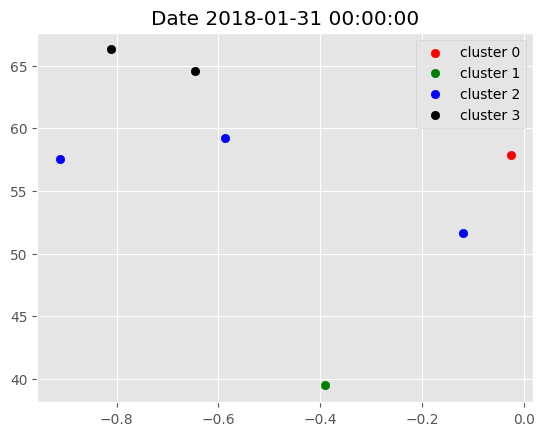

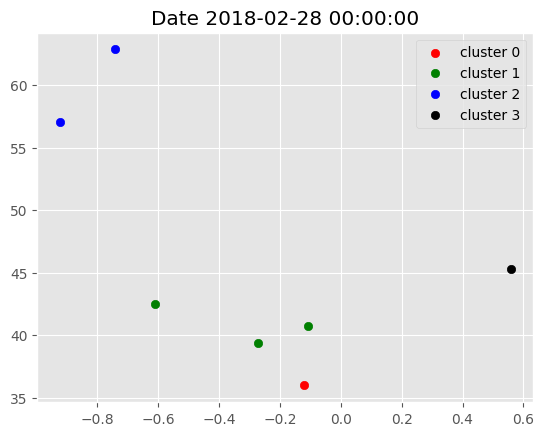

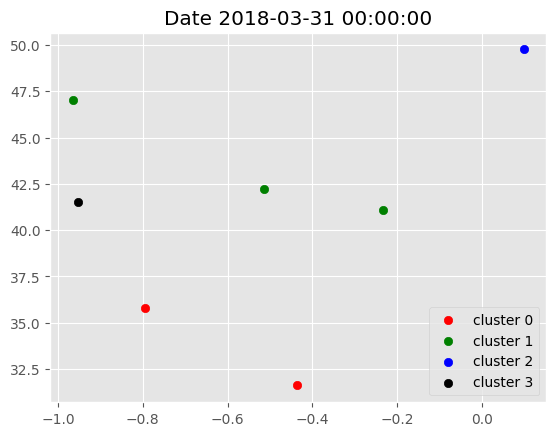

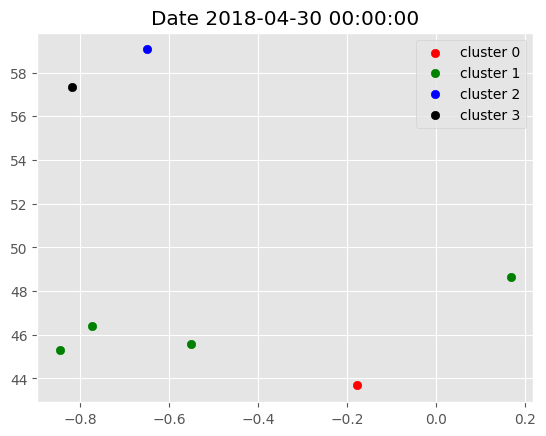

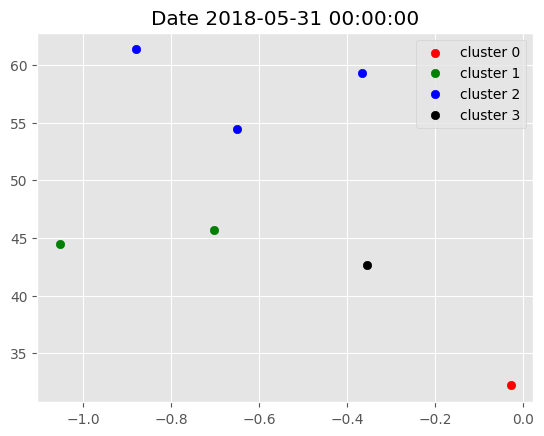

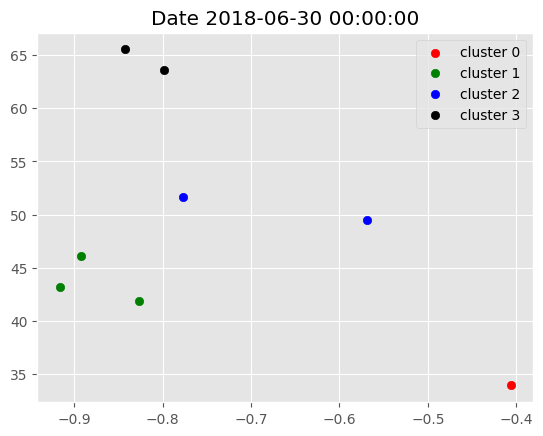

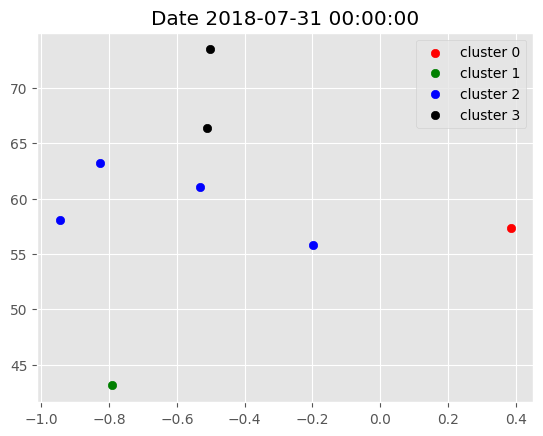

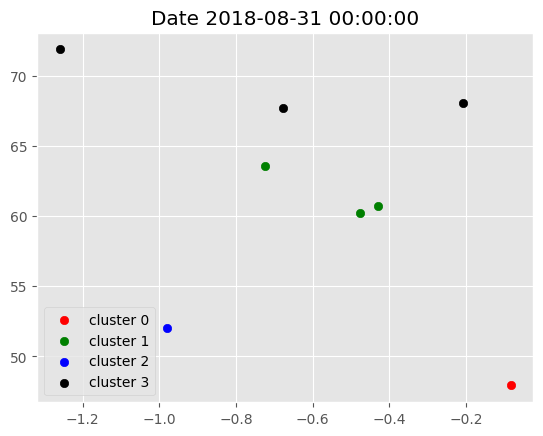

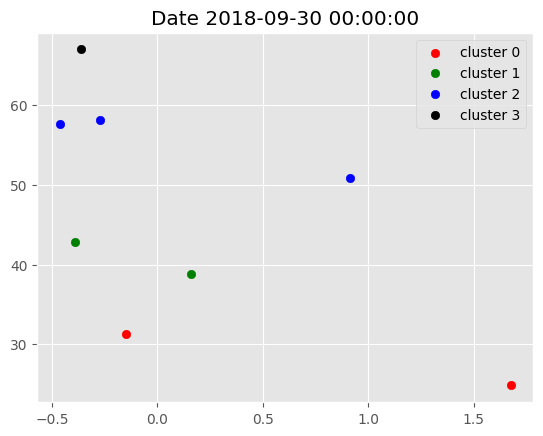

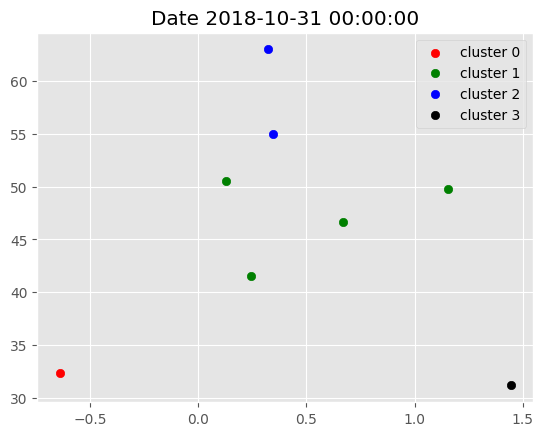

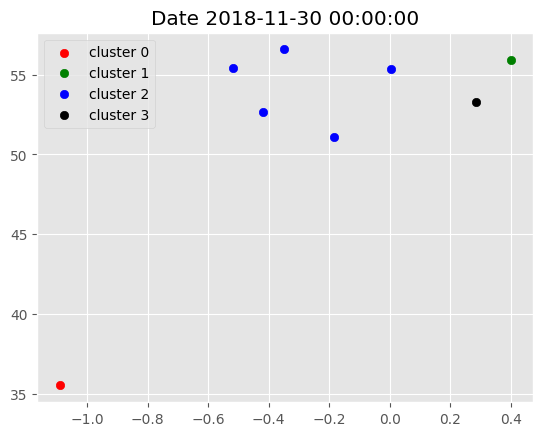

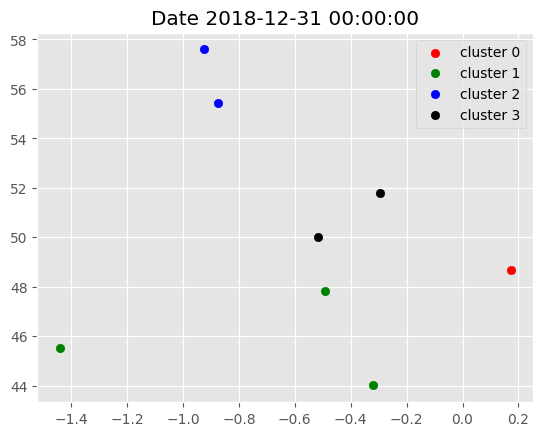

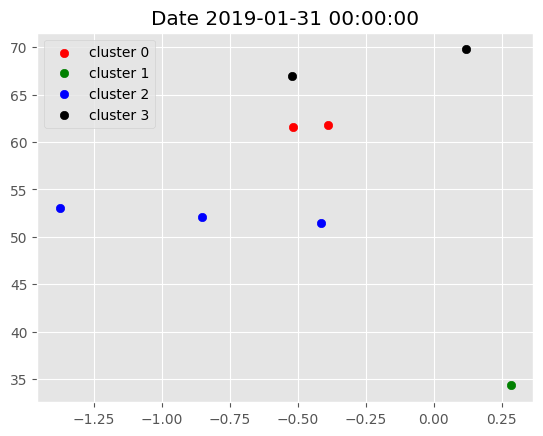

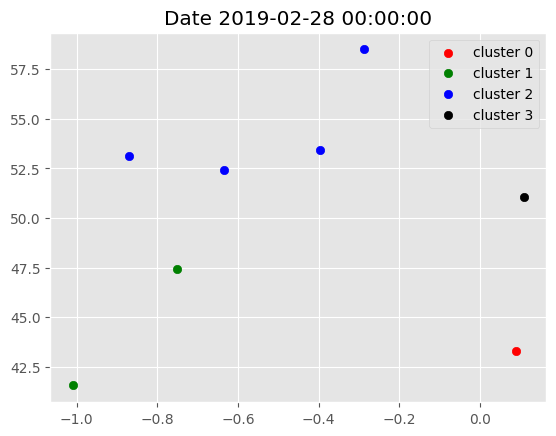

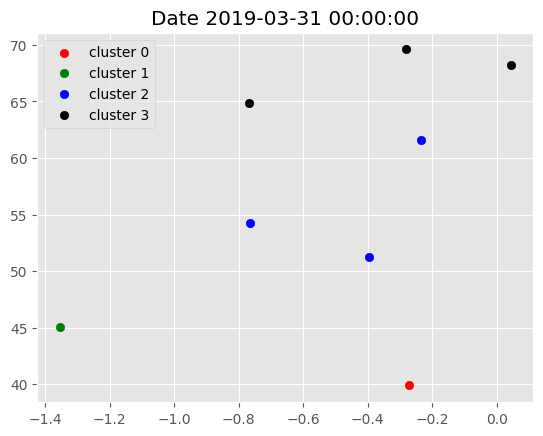

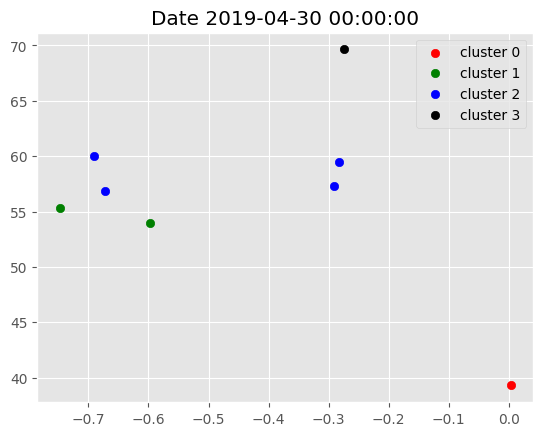

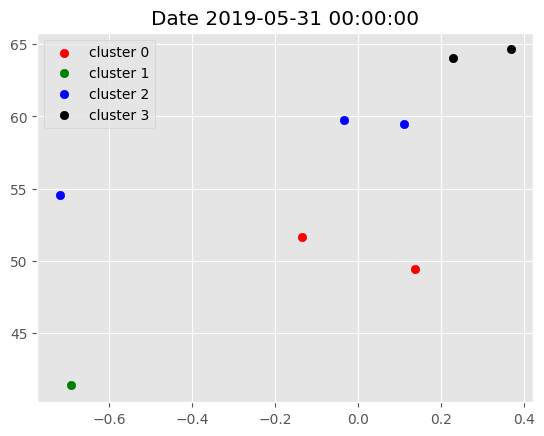

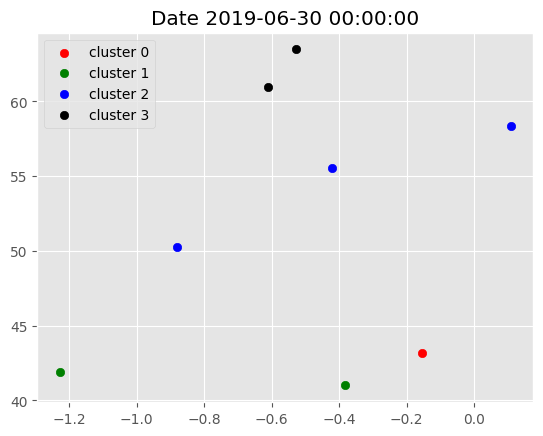

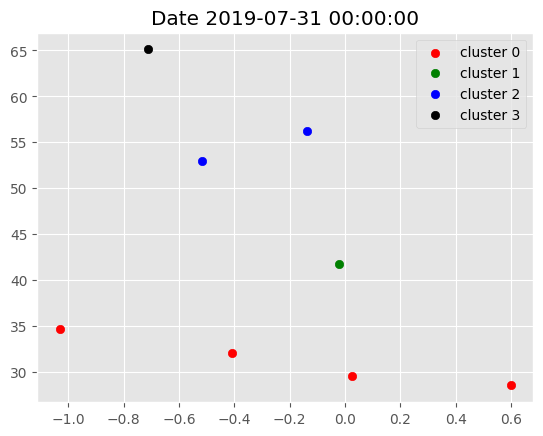

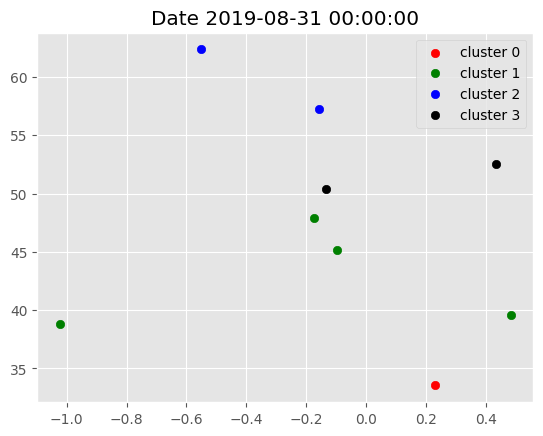

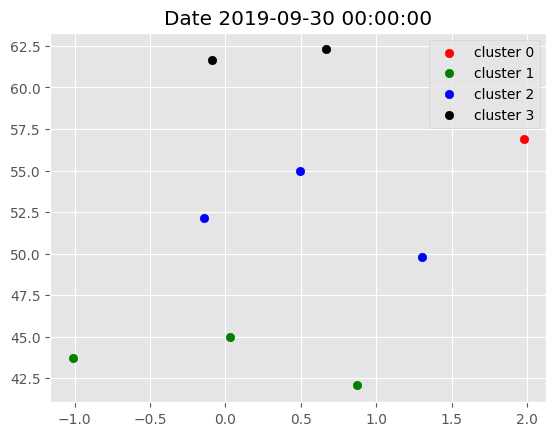

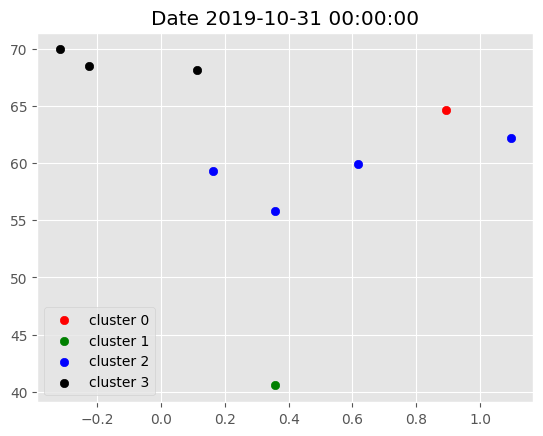

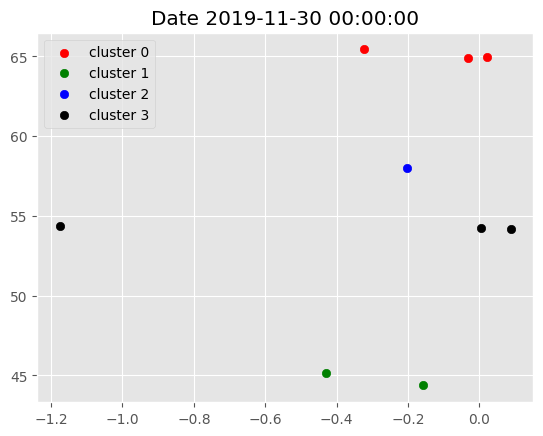

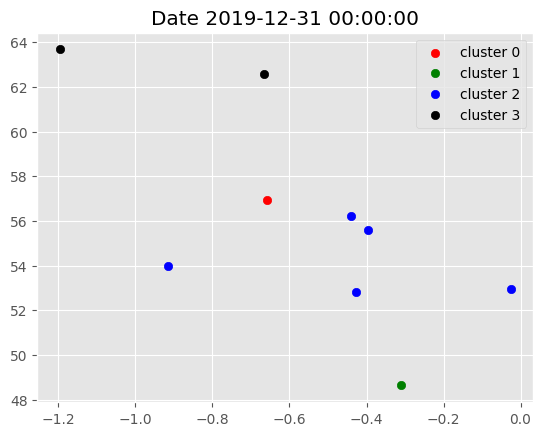

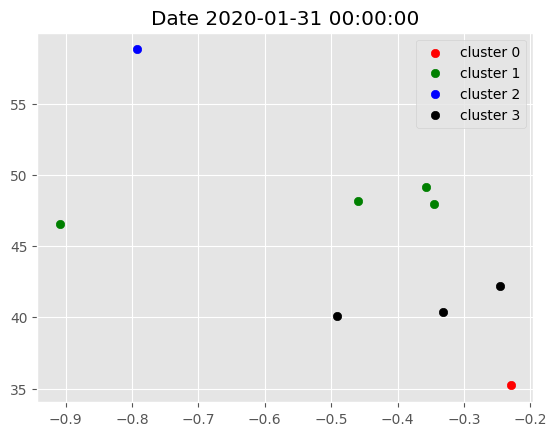

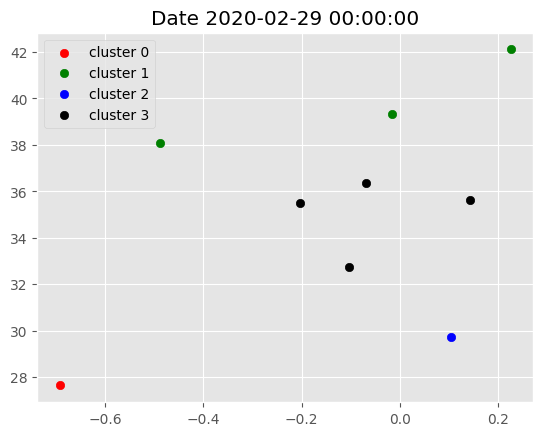

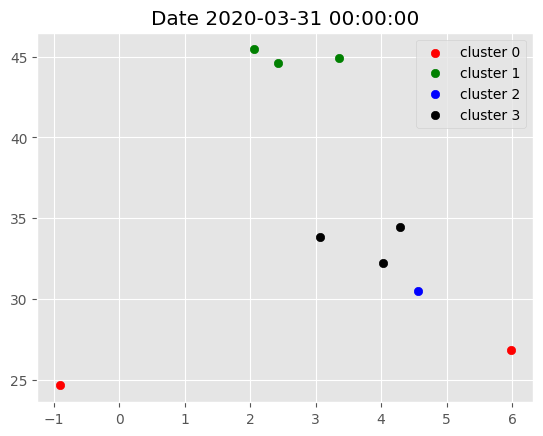

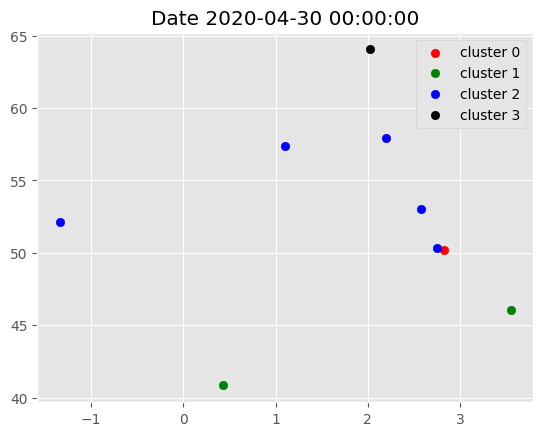

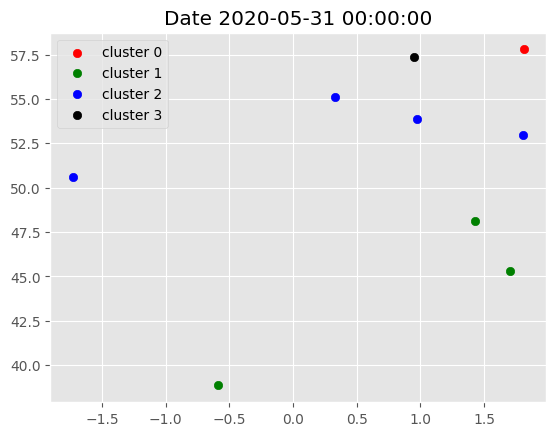

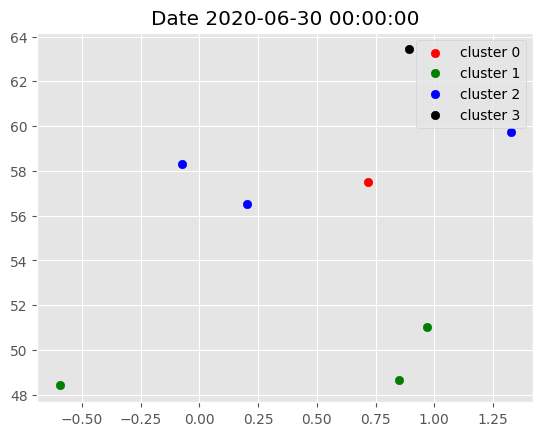

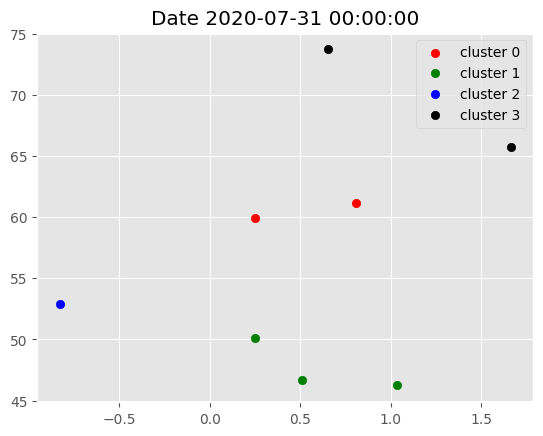

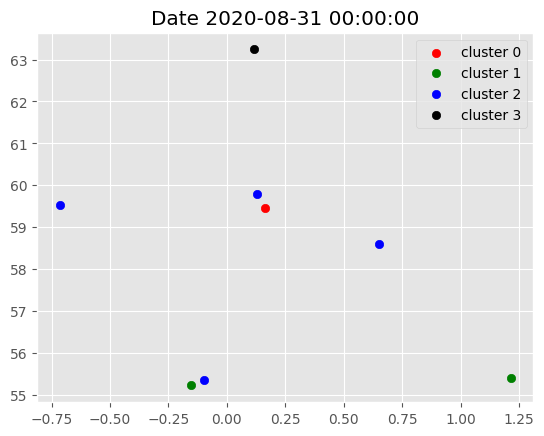

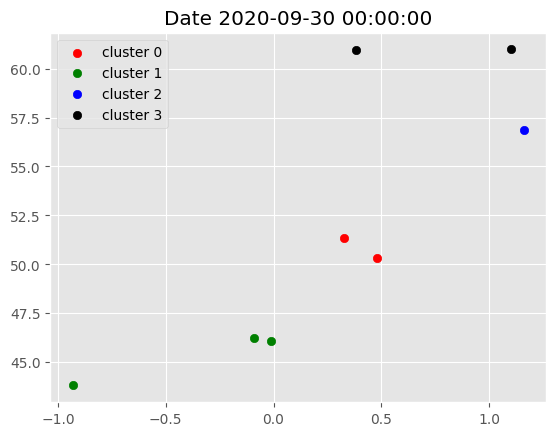

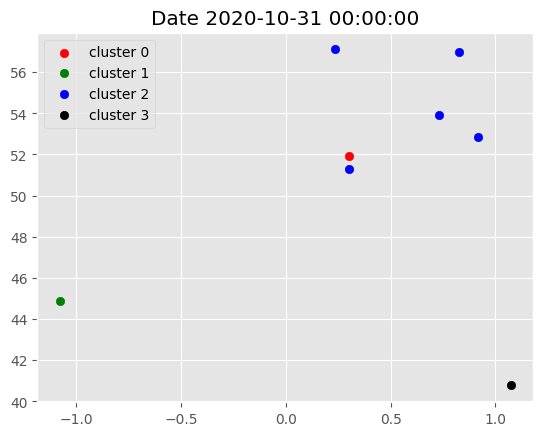

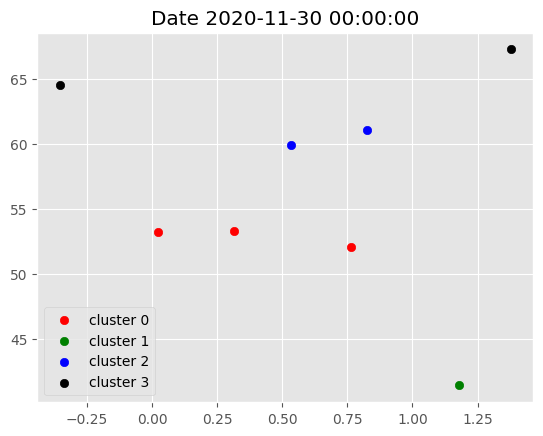

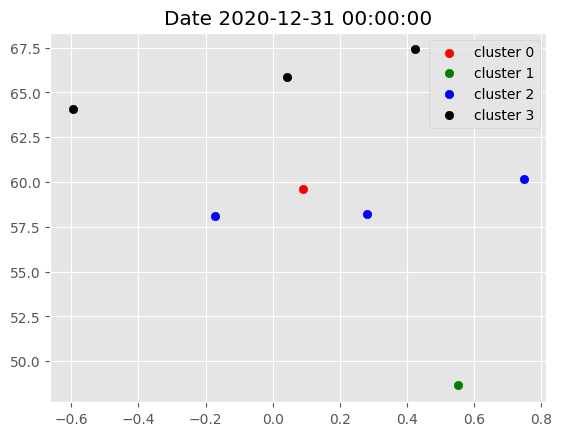

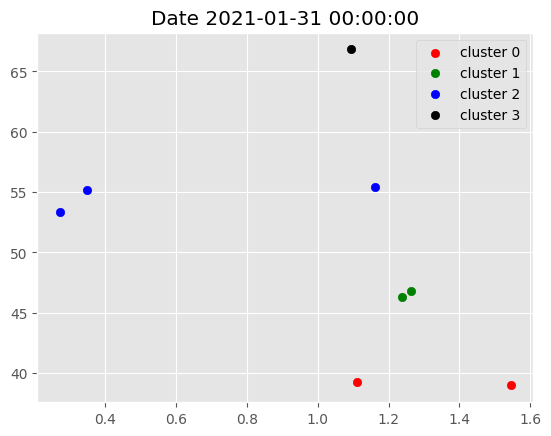

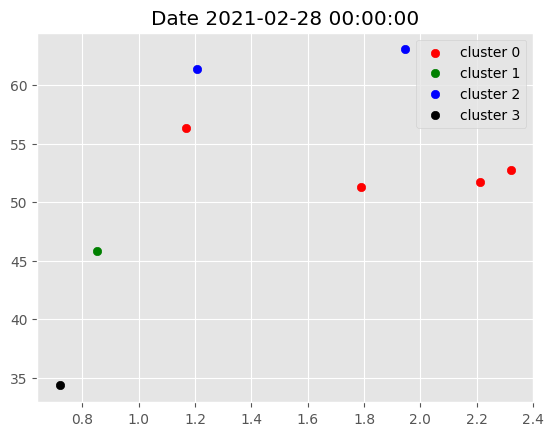

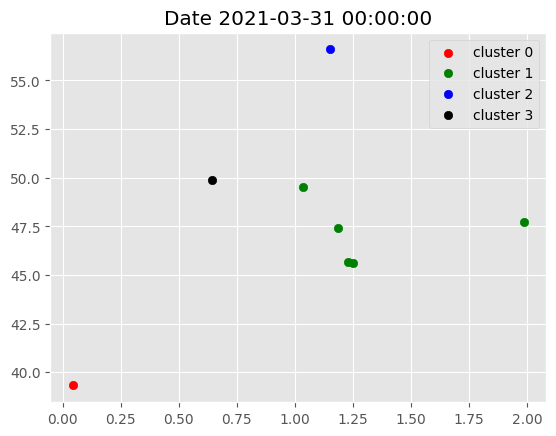

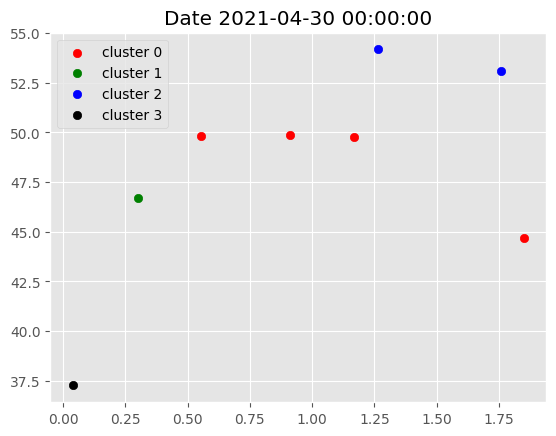

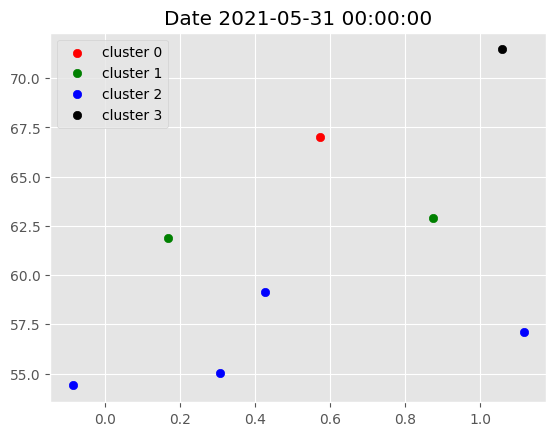

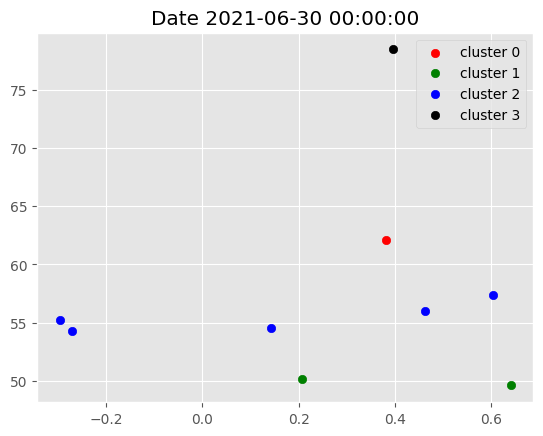

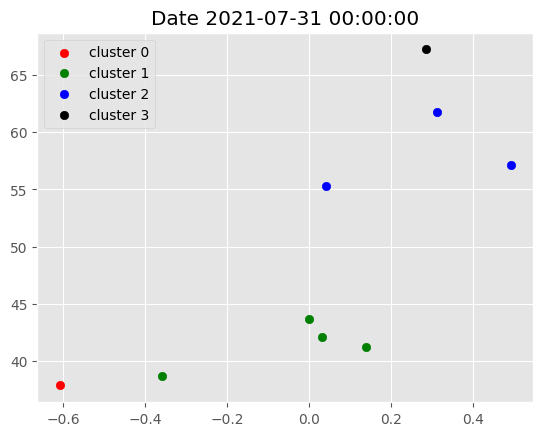

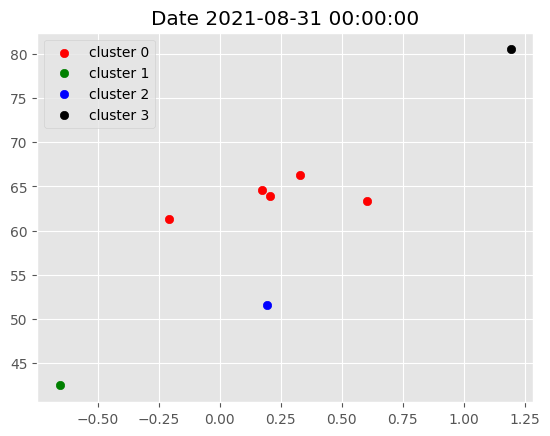

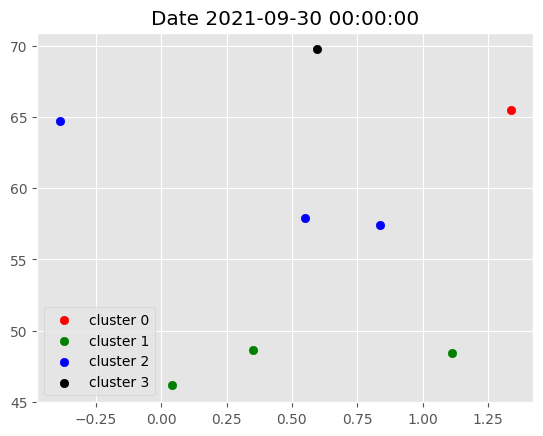

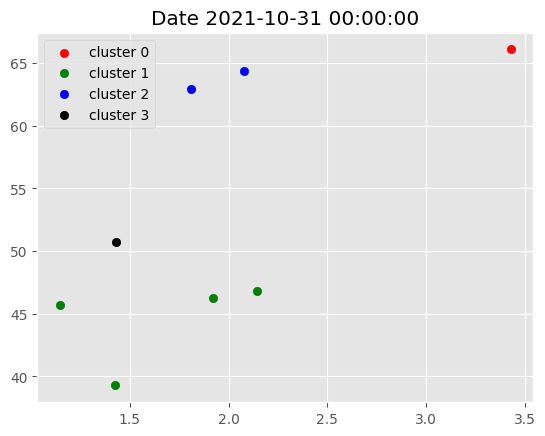

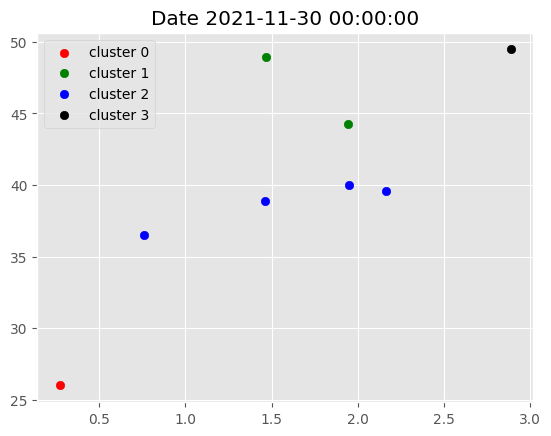

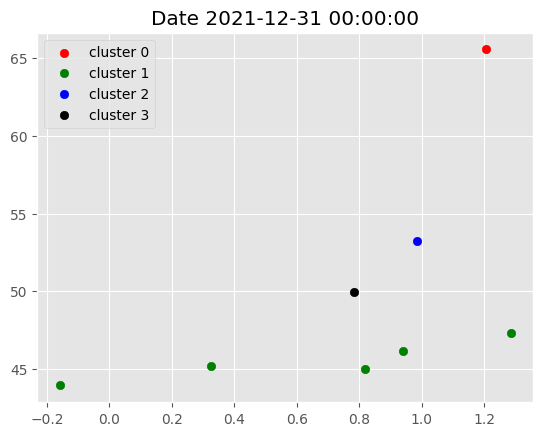

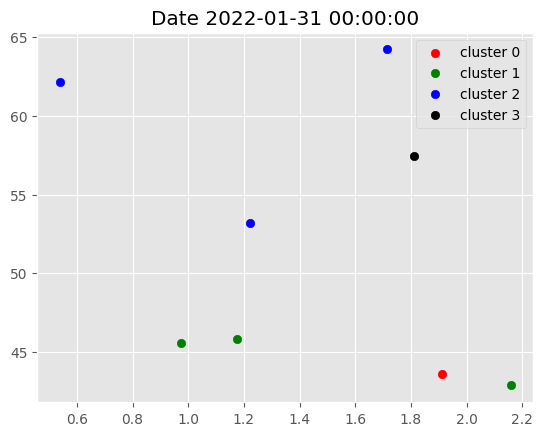

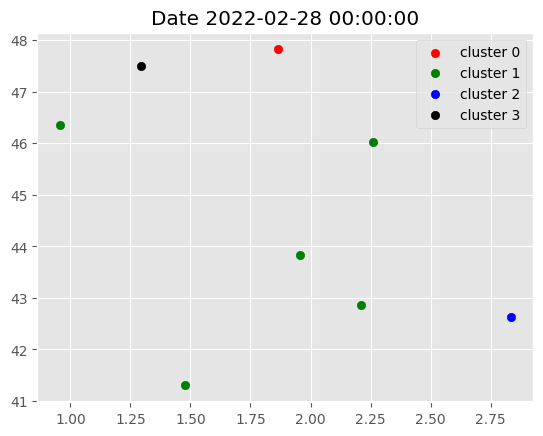

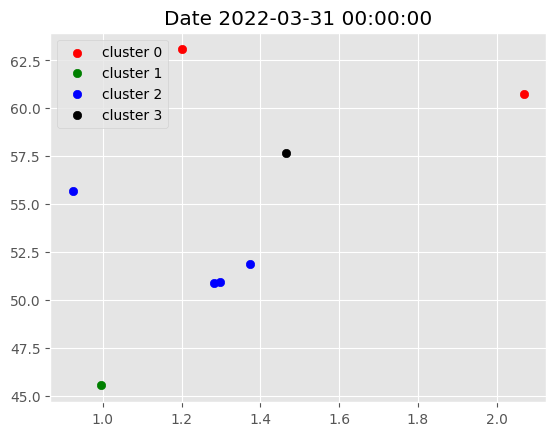

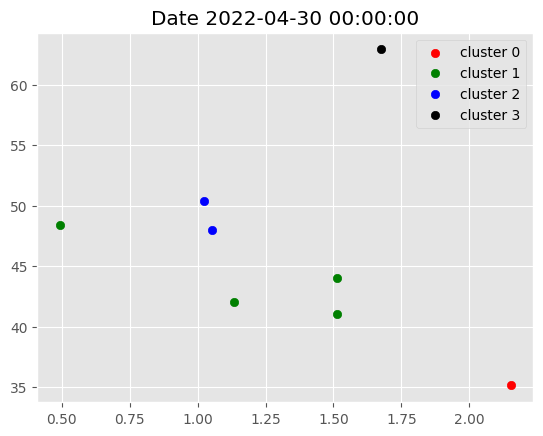

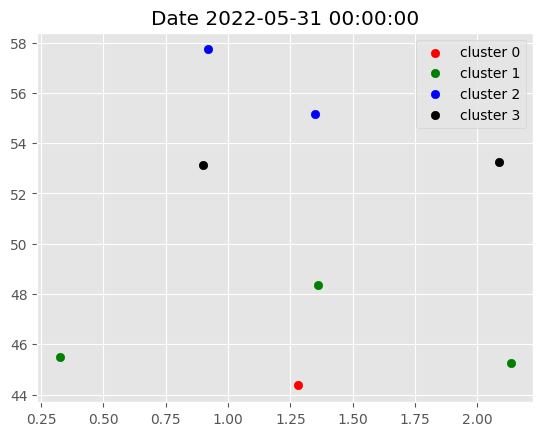

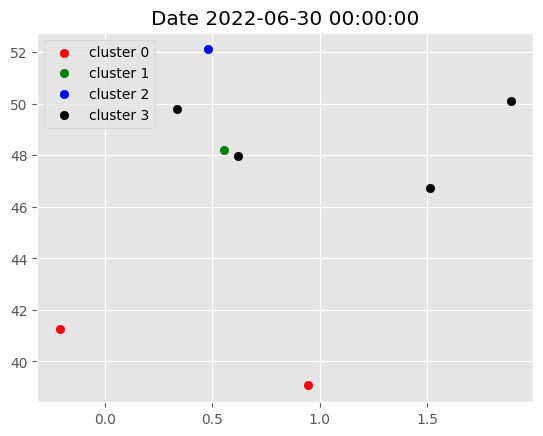

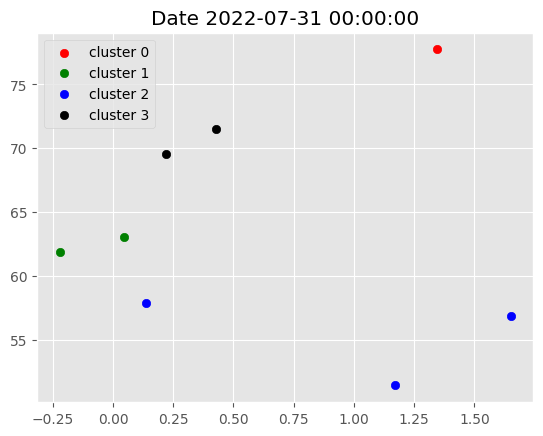

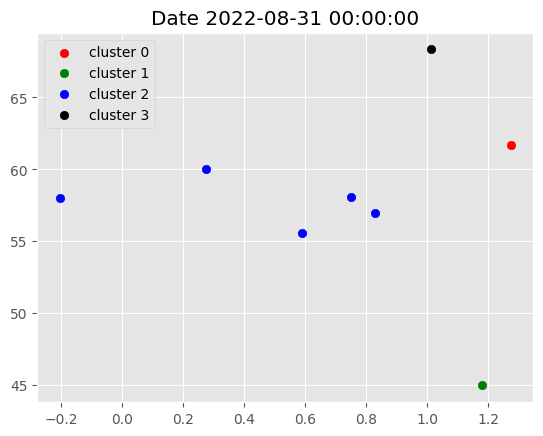

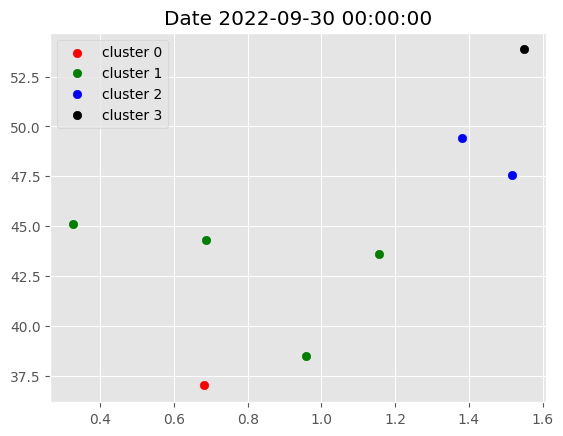

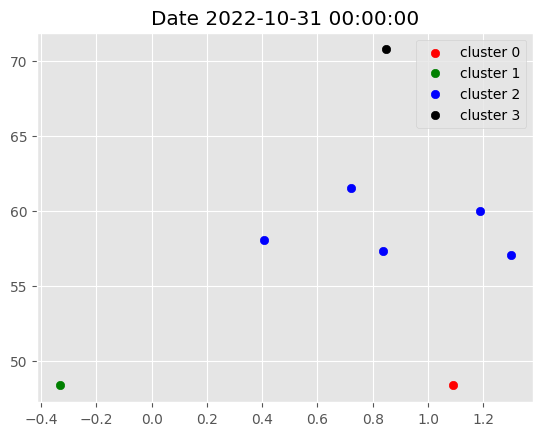

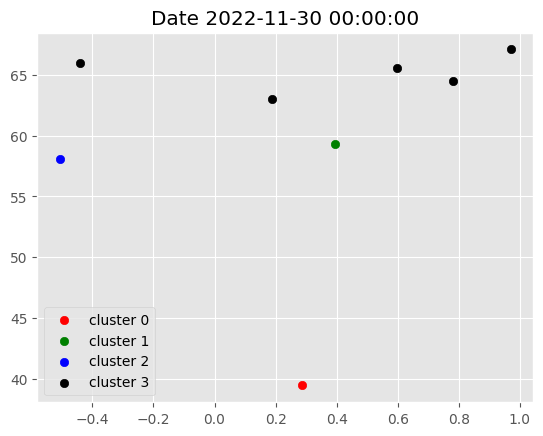

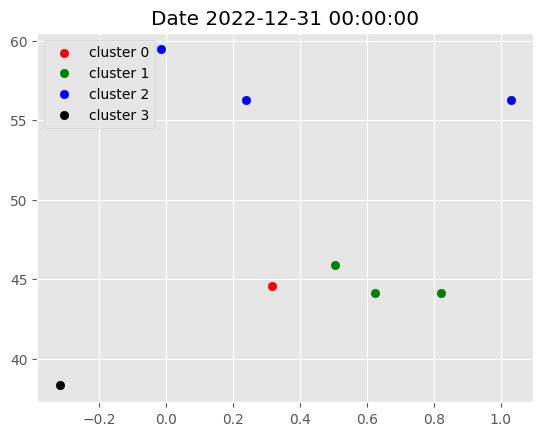

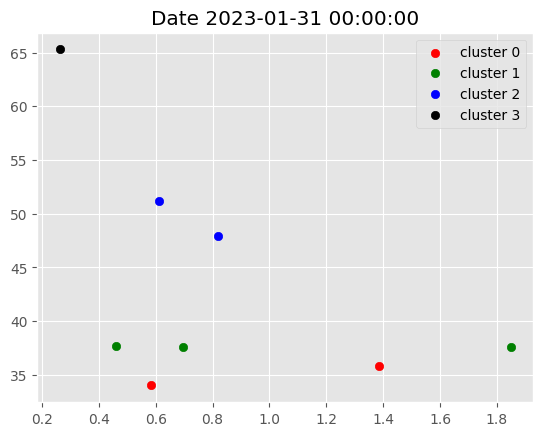

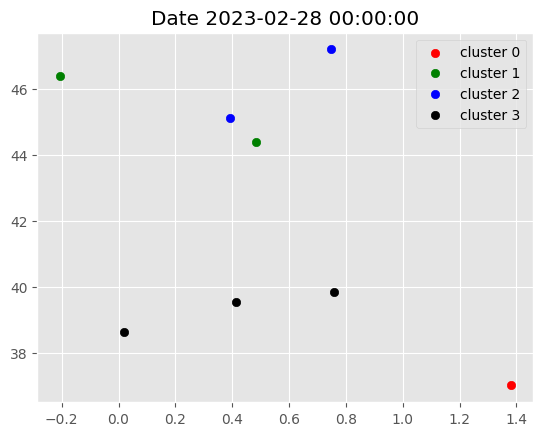

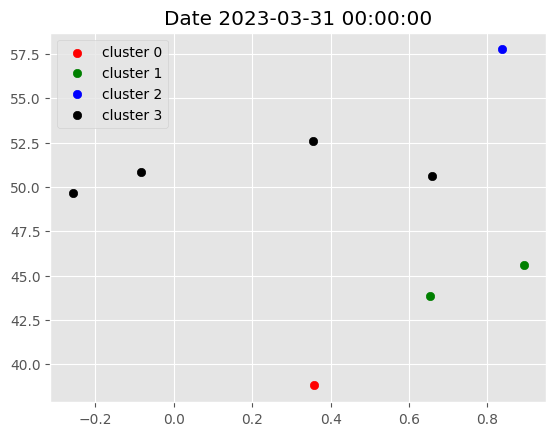

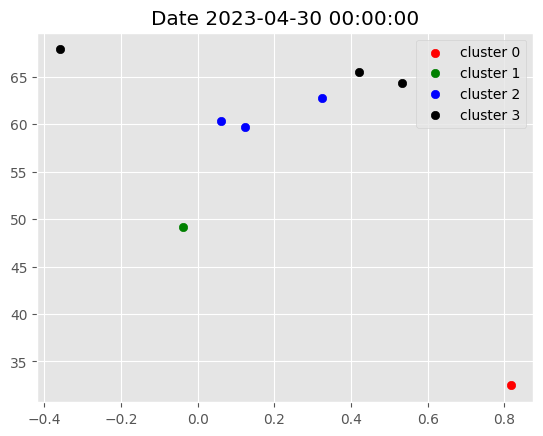

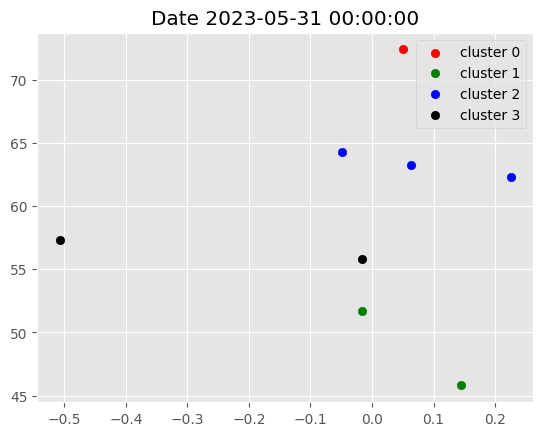

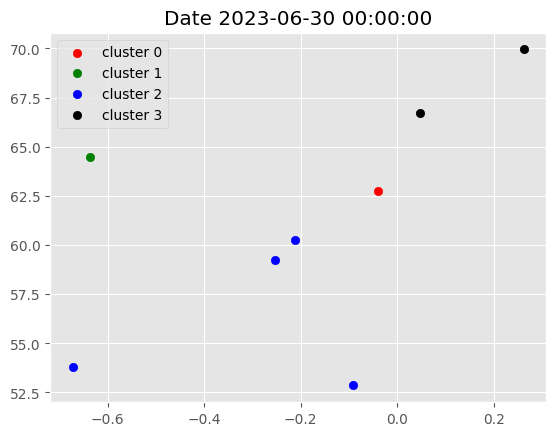

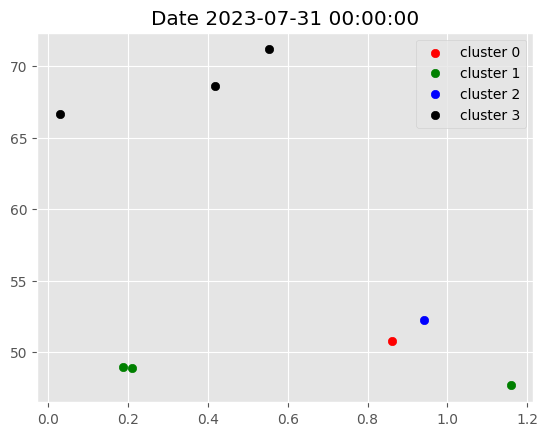

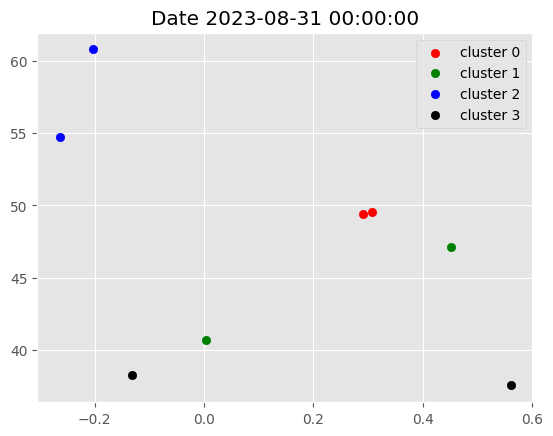

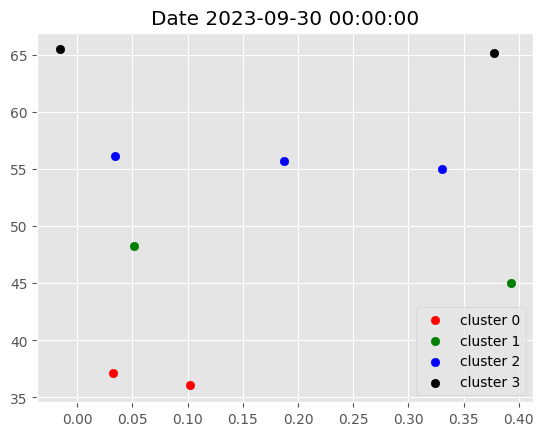

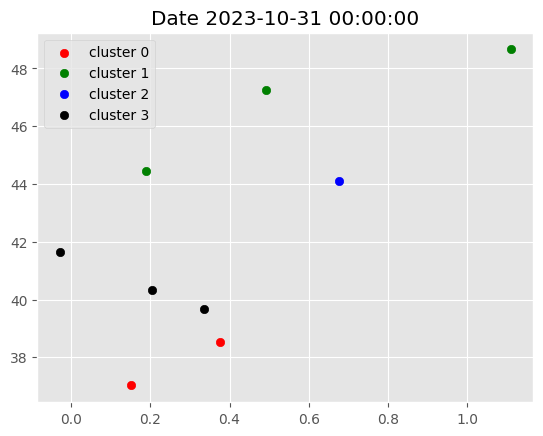

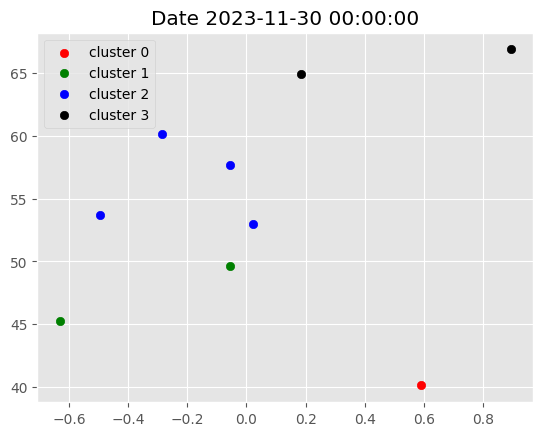

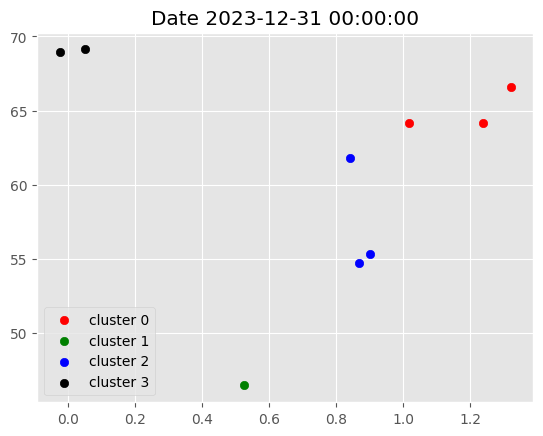

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-02-01': ['ICICIBANK.NS', 'INFY.NS'],
 '2018-03-01': ['MARUTI.NS'],
 '2018-04-01': ['RELIANCE.NS'],
 '2018-05-01': ['RELIANCE.NS'],
 '2018-06-01': ['MARUTI.NS'],
 '2018-07-01': ['INFY.NS', 'TCS.NS'],
 '2018-08-01': ['RELIANCE.NS', 'SBIN.NS'],
 '2018-09-01': ['AXISBANK.NS', 'ICICIBANK.NS', 'TCS.NS'],
 '2018-10-01': ['TCS.NS'],
 '2018-11-01': ['MARUTI.NS'],
 '2018-12-01': ['TCS.NS'],
 '2019-01-01': ['AXISBANK.NS', 'RELIANCE.NS'],
 '2019-02-01': ['AXISBANK.NS', 'INFY.NS'],
 '2019-03-01': ['TCS.NS'],
 '2019-04-01': ['AXISBANK.NS', 'ICICIBANK.NS', 'SBIN.NS'],
 '2019-05-01': ['TCS.NS'],
 '2019-06-01': ['AXISBANK.NS', 'SBIN.NS'],
 '2019-07-01': ['ICICIBANK.NS', 'SBIN.NS'],
 '2019-08-01': ['INFY.NS'],
 '2019-09-01': ['MARUTI.NS', 'RELIANCE.NS'],
 '2019-10-01': ['HDFCBANK.NS', 'RELIANCE.NS'],
 '2019-11-01': ['RELIANCE.NS', 'TATAMOTORS.NS', 'TCS.NS'],
 '2019-12-01': ['AXISBANK.NS', 'MARUTI.NS', 'TATAMOTORS.NS'],
 '2020-01-01': ['ICICIBANK.NS', 'TATAMOTORS.NS'],
 '2020-02-01': ['HDFCBANK.NS

Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.


In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  10 of 10 completed


Adj Close                                                       \
            AXISBANK.NS BAJFINANCE.NS  HDFCBANK.NS ICICIBANK.NS      INFY.NS   
Date                                                                           
2017-01-31   459.724060   1014.178101   612.751831   235.550522   386.057922   
2017-02-01   469.244080   1042.786987   621.824158   246.104095   381.131348   
2017-02-02   476.051147   1031.050171   618.490479   250.308014   389.092834   
2017-02-03   484.091400   1024.399048   624.372070   246.585785   389.175995   
2017-02-06   491.589020   1050.171509   625.824646   254.249191   388.822571   
...                 ...           ...          ...          ...          ...   
2023-12-19  1120.250000   7632.649902  1652.900024  1015.450012  1558.300049   
2023-12-20  1110.250000   7493.950195  1657.000000  1006.650024  1536.400024   
2023-12-21  1095.400024   7367.149902  1686.699951  1004.400024  1536.000000   
2023-12-22  1088.300049   7295.299805  1670.849976   994.299988  1562.900024   
2023-12-26  1093.750000   7160.549805  1681.750000   994.950012  1541.550049   

                                                                              \
               MARUTI.NS  RELIANCE.NS     SBIN.NS TATAMOTORS.NS       TCS.NS   
Date                                                                           
2017-01-31   5529.427246   501.154053  246.929321    521.923340   969.356445   
2017-02-01   5796.741211   503.287750  256.745789    540.565247   942.446716   
2017-02-02   5764.047852   500.338928  259.211731    529.848633   959.726990   
2017-02-03   5736.937012   495.615997  263.242676    520.976257   970.551697   
2017-02-06   5769.066895   499.451813  262.768463    524.216125   974.116699   
...                  ...          ...         ...           ...          ...   
2023-12-19  10233.599609  2558.100098  655.400024    728.950012  3816.199951   
2023-12-20  10081.250000  2527.149902  636.450012    705.250000  3780.050049   
2023-12-21  10012.849609  2562.550049  643.750000    708.849976  3787.500000   
2023-12-22  10217.150391  2565.050049  636.750000    724.700012  3824.000000   
2023-12-26  10260.000000  2578.000000  637.849976    719.150024  3795.250000   

            ...      Volume                                                   \
            ... AXISBANK.NS BAJFINANCE.NS HDFCBANK.NS ICICIBANK.NS   INFY.NS   
Date        ...                                                                
2017-01-31  ...    10629001       2304584     3050520     20535165  24068534   
2017-02-01  ...     8340303       1860379     5455332     44647342  11531782   
2017-02-02  ...     7557596       1681729     2985818     28910922  11828268   
2017-02-03  ...     7134563        903079     4002552     20058936   8423958   
2017-02-06  ...     8575116       1218063     2155110     22521926   6727934   
...         ...         ...           ...         ...          ...       ...   
2023-12-19  ...     6824641        791408    12004223     10094256   4221721   
2023-12-20  ...     9848057        874546    17116260     16490281   6592367   
2023-12-21  ...    10914682        913082    18294620     18064916   5319038   
2023-12-22  ...    10600025       1129485    24289425     20881976   6741060   
2023-12-26  ...     5049508       1080987     7776068     12882802   6190395   

                                                                   
           MARUTI.NS RELIANCE.NS   SBIN.NS TATAMOTORS.NS   TCS.NS  
Date                                                               
2017-01-31    374637     6980274   8899165       6035022  4666804  
2017-02-01   1212008     5220617  27253142       4786720  4864152  
2017-02-02    745214     4199246  20139955       6579801  6009482  
2017-02-03    304078     6100788  15366890       5298261  2153372  
2017-02-06    322223     4611263  14725291       3642527  2408910  
...              ...         ...       ...           ...      ...  
2023-12-19    585734     8410302  19964

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights

,Strategy Return
date,
2018-02-01,-0.012117
2018-02-02,-0.016884
2018-02-05,-0.010337
2018-02-06,-0.012044
2018-02-07,0.003376
...,...
2023-12-19,0.002721
2023-12-20,-0.021010
2023-12-21,-0.004187


8. Visualize Portfolio returns and compare to nifty returns.


In [18]:
nft = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nft_ret = np.log(nft[['Adj Close']]).diff().dropna().rename({'Adj Close':'NIFTY  50 Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nft_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,NIFTY 50 Buy&Hold
2018-02-01,-0.012117,-0.000980
2018-02-02,-0.016884,-0.023539
2018-02-05,-0.010337,-0.008779
2018-02-06,-0.012044,-0.015904
2018-02-07,0.003376,-0.002055
...,...,...
2023-12-18,-0.005126,-0.001773
2023-12-19,0.002721,0.001607
2023-12-20,-0.021010,-0.014222
2023-12-21,-0.004187,0.004948


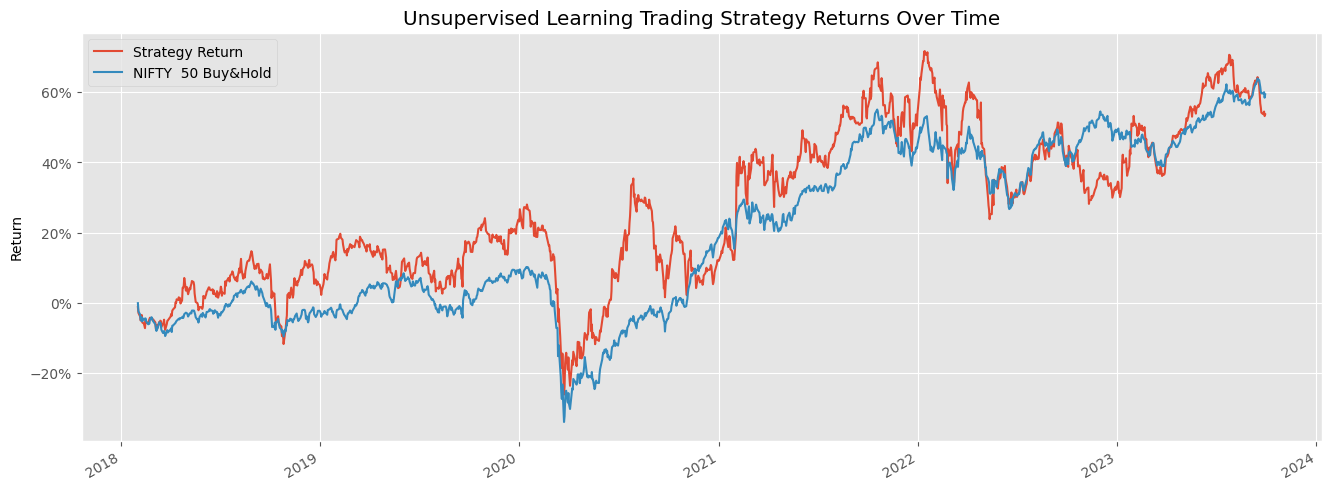

In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()